In [1]:
import pandas as pd
import sklearn.tree as sktree
import scipy as sp
import os
path="./데이터/"
filename=os.listdir(path)

## 변수설정

### Target(Y)

target = 침수여부

In [2]:
target=pd.read_csv(f"{path}침수지역2022.csv")

위의 데이터는 침수지역의 빈도(frequency)이므로 바꿔야함

In [3]:
print('한번이라도 침수가 일어난 지역수(행정동) :',target["ADM_NM"].nunique())

한번이라도 침수가 일어난 지역수(행정동) : 277


In [4]:
target["ADM_NM"]

0         우이동
1         우이동
2         우이동
3        영등포동
4         송중동
        ...  
8882      청파동
8883      한남동
8884    원효로2동
8885      동선동
8886    북가좌2동
Name: ADM_NM, Length: 8887, dtype: object

### Feature(X)

In [5]:
filename

['2022_강우량_관측소별',
 '2022년 침수흔적도_230717수정',
 'B422. 서울시 누적강수량(월평균) 공간데이터',
 'B422. 서울시 누적강수량(월평균) 공간데이터.zip.001',
 'data2.csv',
 'elevation.csv',
 'information_gain.csv',
 'LSMD_CONT_UQ123_서울',
 'mnum_data.csv',
 'ufid_data.csv',
 'Z_SIS_ASIT_SOILDRA_AREA.xlsx',
 '경사도.xlsx',
 '고도',
 '공시지가_2019평균.csv',
 '공시지가_2019평균.xlsx',
 '공원(UTM).csv',
 '기초생활수급자+65세이상.csv',
 '기초수급자.csv',
 '노인.csv',
 '노인층.csv',
 '노후기간별+주택현황_20231114172801.csv',
 '단속실적.xlsx',
 '데이터',
 '도로 교차영역.csv',
 '도로 중복값제거.csv',
 '도로현황(도로율)_20231015181102.csv',
 '동별_인구_고도_배수등급_공시지가.csv',
 '동별_인구_고도_배수등급_공시지가_결합.csv',
 '동별_인구_고도_배수등급_공시지가_결합_인코딩.csv',
 '모아보기.csv',
 '반출_행정동_소득가구_수정2차.xlsx',
 '배수등급양호비율.csv',
 '빗물저류시설유지관리시설현황_2030하수도정비기본계획_2015.xlsx',
 '빗물펌프장_2030하수도정비기본계획_2015.xlsx',
 '서울시 도시계획 정비사업 현황.csv',
 '서울시 행정동.csv',
 '서울시_강우량_정보_2021년',
 '서울시_강우량_정보_2022년',
 '서울시_행정동별_인구밀도_2023.csv',
 '서울특별시_양천구_빗물펌프장현황_20220925.csv',
 '수문.csv',
 '실폭하천.csv',
 '암거.csv',
 '여성.csv',
 '장애인.csv',
 '재해위험지구_경계도.csv',
 '제방.csv',
 '제방암거수문_있다없다.csv',
 '제

In [6]:
경사도 = pd.read_excel(path + "/경사도.xlsx")
도로율 = pd.read_csv(path + "/" + "도로현황(도로율)_20231015181102.csv")
제방암거수문 = pd.read_csv(path + "/" + "제방암거수문_있다없다.csv")
행정동소득분위 = pd.read_excel(path + "/" + "반출_행정동_소득가구_수정2차.xlsx")
배수등급양호비율 = pd.read_csv(path + "/" + "배수등급양호비율.csv")
하천까지의거리 = pd.read_csv(path + "/" + "하천까지의_거리.csv")
인구밀도 = pd.read_csv(path + "/" + "서울시_행정동별_인구밀도_2023.csv")
정비산업 = pd.read_csv(path + "/" + "서울시 도시계획 정비사업 현황.csv")


사회인프라

In [7]:
장애인=pd.read_csv(path+"/"+"장애인.csv")
노인=pd.read_csv(path+"/"+'노인.csv')
기초수급자=pd.read_csv(path+"/"+"기초수급자.csv")
기초수급자_65세이상=pd.read_csv(path+"/"+'기초생활수급자+65세이상.csv')

강우량

In [8]:
path3=path+'서울시_강우량_정보_2022년/'

In [9]:
rain_dict={}
for i in range(1,13):
    rain_dict[i]=pd.read_csv(path3+f'서울시_강우량_정보_2022년{i}월.csv',encoding='euc-kr')

In [10]:
rain_data=pd.concat([rain_dict[i][rain_dict[i]["10분우량"]!=0] for i in range(1,13)])
rain_agg=rain_data.groupby(["구청명"])["10분우량"].agg(["sum","count"])
rain_agg.rename(columns=dict(zip(["sum","count"],["누적강수량","10분당 측정(횟수)"])),inplace=True)
rain_agg.index.rename(None,inplace=True)

In [11]:
rain_agg["추정시우량(연간)"]=rain_agg["누적강수량"]/(rain_agg["10분당 측정(횟수)"]/6)

In [12]:
rain_agg.index.rename("시군구",inplace=True)
rain_agg.reset_index(inplace=True)

In [13]:
구면적=pd.DataFrame(인구밀도.groupby(["구"])["면적 (k㎡)"].sum()).reset_index()
구면적.rename(columns={"구":"시군구"},inplace=True)

In [14]:
rain_agg=pd.merge(rain_agg,구면적)
rain_agg["추정면적당시우량(연간)"]=rain_agg["추정시우량(연간)"]/rain_agg["면적 (k㎡)"]

In [15]:
rain_agg

,시군구,누적강수량,10분당 측정(횟수),추정시우량(연간),면적 (k㎡),추정면적당시우량(연간)
0,강남구,5187.0,3025,10.288264,39.51,0.260396
1,강동구,3426.5,2300,8.938696,24.59,0.363509
2,강북구,1803.5,1382,7.829957,23.60,0.331778
3,강서구,2690.5,2053,7.863127,41.44,0.189747
4,관악구,3461.0,2176,9.543199,29.57,0.322732
5,광진구,1887.0,1353,8.368071,17.06,0.490508
6,구로구,3246.5,1962,9.928135,20.12,0.493446
7,금천구,3270.0,2091,9.383070,13.02,0.720666
8,노원구,3290.5,2312,8.539360,35.44,0.240953
9,도봉구,1932.0,1435,8.078049,20.65,0.391189


### 데이터 병합

행정동 단위
> 경사도, 행정공시지가, 배수등급양호비율, 하천까지의 거리, 제방수문암거

In [16]:
import PublicDataReader as pdr
행정동코드 = pdr.code_hdong()
import numpy as np
행정동=행정동코드[행정동코드["시도명"]=="서울특별시"][["시군구명","읍면동명"]]
행정동.index=행정동.index.astype('int')
행정동["시군구명"]=행정동["시군구명"].str.strip()
행정동["읍면동명"]=행정동["읍면동명"].str.strip()
행정동=행정동[행정동["시군구명"]!=""][행정동["읍면동명"]!=""]

출처: 행정기관(행정동) 및 관할구역(법정동) 변경내역(2023.10.30. 시행)


C:\Users\yis82\AppData\Local\Temp\ipykernel_18968\2488655424.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  행정동=행정동[행정동["시군구명"]!=""][행정동["읍면동명"]!=""]


----------

In [17]:
per_경사도=pd.DataFrame(경사도.groupby(["ADM_NM"])["경사도"].mean())
per_경사도.reset_index(inplace=True)

In [18]:
pre_경사도=pd.merge(경사도[["GU_NAME","ADM_NM"]],per_경사도,how='left')
pre_경사도["경사도(%)"]=pre_경사도["경사도"]*100
pre_경사도.drop_duplicates(["ADM_NM"],inplace=True)

In [19]:
pre_경사도

,GU_NAME,ADM_NM,경사도,경사도(%)
0,종로구,이화동,0.078333,7.833333
1,종로구,숭인2동,0.053125,5.312500
2,종로구,혜화동,0.078333,7.833333
3,중구,광희동,0.072500,7.250000
4,중구,을지로동,0.040000,4.000000
...,...,...,...,...
3234,관악구,난곡동,0.231667,23.166667
3427,금천구,시흥2동,0.377857,37.785714
3431,관악구,난향동,0.330000,33.000000
3464,금천구,독산2동,0.142667,14.266667


In [20]:
배수등급양호비율[["GU_NAME","ADM_NM","양호비율"]]

,GU_NAME,ADM_NM,양호비율
0,송파구,가락1동,0.654167
1,송파구,가락2동,0.842105
2,송파구,가락본동,0.680000
3,구로구,가리봉동,0.688073
4,금천구,가산동,0.610245
...,...,...,...
412,용산구,효창동,0.980769
413,용산구,후암동,1.000000
414,동대문구,휘경1동,0.405797
415,동대문구,휘경2동,0.300578


In [21]:
하천까지의거리[["GU_NAME","ADM_NM","HubDist"]]  

,GU_NAME,ADM_NM,HubDist
0,종로구,사직동,961.440982
1,종로구,삼청동,481.426072
2,종로구,부암동,719.095967
3,종로구,평창동,70.039725
4,종로구,무악동,1381.962564
...,...,...,...
419,강동구,둔촌1동,1112.581499
420,강동구,둔촌2동,286.658161
421,강동구,암사1동,1421.991249
422,강동구,천호2동,713.146580


In [22]:
제방암거수문
# 암거는 모두 가지고 있음

,GU_NAME,ADM_NM,비고,count,제방,수문,암거
0,강남구,개포1동,제방,65,1,1,1
1,강남구,개포1동,암거,58,1,1,1
2,강남구,개포1동,수문,4,1,1,1
3,강남구,개포2동,암거,95,1,1,1
4,강남구,개포2동,제방,30,1,1,1
...,...,...,...,...,...,...,...
833,중랑구,중화1동,암거,12,1,0,1
834,중랑구,중화1동,제방,4,1,0,1
835,중랑구,중화2동,암거,26,1,1,1
836,중랑구,중화2동,제방,12,1,1,1


In [23]:
인구밀도[["구","행정동","인구밀도(명/km²)"]]

,구,행정동,인구밀도(명/km²)
0,종로구,사직동,7618.699187
1,종로구,삼청동,1755.704698
2,종로구,부암동,4167.400881
3,종로구,평창동,2000.338219
4,종로구,무악동,22347.222220
...,...,...,...
421,강동구,둔촌1동,80.434783
422,강동구,둔촌2동,15520.512820
423,강동구,강일동,14638.053100
424,강동구,상일1동,21667.582420


In [24]:
행정동소득분위[["읍면동","1분위소득가구비율(%)","2분위소득가구비율(%)"
         ,"3분위소득가구비율(%)","4분위소득가구비율(%)","5분위소득가구비율(%)"]]

,읍면동,1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%)
0,사직동,0.158391,0.142992,0.214959,0.180704,0.302640
1,삼청동,0.240190,0.211653,0.229489,0.184304,0.133175
2,부암동,0.177386,0.169309,0.195334,0.212384,0.245588
3,평창동,0.119703,0.139261,0.173669,0.199565,0.367983
4,무악동,0.157974,0.118292,0.160620,0.181028,0.381708
...,...,...,...,...,...,...
418,성내3동,0.180404,0.192774,0.234538,0.218861,0.173423
419,둔촌2동,0.137338,0.148917,0.193626,0.235011,0.285108
420,암사1동,0.203770,0.215738,0.236557,0.199754,0.144180
421,천호2동,0.233815,0.231585,0.235276,0.192373,0.106951


In [25]:
행정동=pd.merge(배수등급양호비율[["GU_NAME","ADM_NM","양호비율"]]
             ,제방암거수문[["GU_NAME","ADM_NM","제방","수문"]],how="left")
행정동=pd.merge(행정동,pre_경사도,how='left')
행정동.drop("경사도",axis=1,inplace=True)
행정동.rename(columns={"양호비율":"배수등급양호비율","경사도(%)":"평균경사도(%)"},inplace=True)
행정동=pd.merge(행정동,하천까지의거리[["GU_NAME","ADM_NM","HubDist"]],how="left").rename(columns={"HubDist":"하천까지의거리(중심)"})
행정동=pd.merge(행정동,인구밀도[["구","행정동","인구밀도(명/km²)"]].rename(columns={"구":"GU_NAME","행정동":"ADM_NM"}),how="left")
행정동=pd.merge(행정동,행정동소득분위[["읍면동","1분위소득가구비율(%)","2분위소득가구비율(%)"
         ,"3분위소득가구비율(%)","4분위소득가구비율(%)","5분위소득가구비율(%)"]].rename(columns=
                                                                {'읍면동':"ADM_NM"}),how='left')
# 행정동=pd.merge(행정동
#              ,행정공시지가[행정공시지가.columns[[0,1,-1]]].rename(
#                  columns=dict(zip(행정공시지가.columns[[0,1]],["GU_NAME","ADM_NM"]))),how="left")


In [26]:
len(행정동)

830

In [27]:
행정동.head()

,GU_NAME,ADM_NM,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%)
0,송파구,가락1동,0.654167,1.0,0.0,3.812500,542.994437,20605.22388,0.069767,0.106977,0.153488,0.223256,0.441860
1,송파구,가락1동,0.654167,1.0,0.0,3.812500,542.994437,20605.22388,0.069767,0.106977,0.153488,0.223256,0.441860
2,송파구,가락2동,0.842105,0.0,0.0,7.125000,1074.589206,32888.54167,0.122453,0.148780,0.180452,0.243292,0.305124
3,송파구,가락본동,0.680000,0.0,0.0,10.785714,2056.158356,22821.23894,0.124626,0.175075,0.205002,0.235357,0.259833
4,구로구,가리봉동,0.688073,0.0,0.0,9.666667,1184.743571,31655.00000,0.393553,0.283377,0.169112,0.115949,0.038008


In [28]:
행정동.isna().sum()

GU_NAME          0
ADM_NM           0
배수등급양호비율         0
제방               2
수문               2
평균경사도(%)         6
하천까지의거리(중심)      0
인구밀도(명/km²)     23
1분위소득가구비율(%)    19
2분위소득가구비율(%)    19
3분위소득가구비율(%)    19
4분위소득가구비율(%)    19
5분위소득가구비율(%)    19
dtype: int64

Nan값 삭제

In [29]:
행정동.dropna(inplace=True)

--------

자치구별

In [30]:
도로율[["자치구별(2)","2022.2"]]

,자치구별(2),2022.2
0,자치구별(2),도로율 (%)
1,소계,23.35
2,종로구,21.15
3,중구,18.86
4,용산구,23.44
5,성동구,24.26
6,광진구,29.13
7,동대문구,22.74
8,중랑구,25.60
9,성북구,23.18


In [31]:
장애인[["동별(2)","장애인_per"]]

,동별(2),장애인_per
0,종로구,0.042206
1,중구,0.047262
2,용산구,0.035601
3,성동구,0.040202
4,광진구,0.036498
5,동대문구,0.046458
6,중랑구,0.053083
7,성북구,0.040730
8,강북구,0.059247
9,도봉구,0.049010


In [32]:
시군구=pd.merge(도로율[["자치구별(2)","2022.2"]].loc[2:].rename(columns=dict(zip(["자치구별(2)","2022.2"],["동별(2)","도로율"])))
             ,노인[["동별(2)","노인_per"]])
시군구=pd.merge(시군구,장애인[["동별(2)","장애인_per"]])
시군구=pd.merge(시군구,기초수급자_65세이상[["자치구별(2)","per(기초생활수급자)",'per(기초생활수급자+65세이상)']].rename(
    columns=dict(zip(["자치구별(2)","per(기초생활수급자)",'per(기초생활수급자+65세이상)']
                     ,["동별(2)","기초생활수급자_per",'기초생활수급자+65세이상_per']))
))
시군구=pd.merge(시군구,rain_agg[["시군구","추정면적당시우량(연간)"]].rename(columns={"시군구":"동별(2)"}))
시군구[[y for y in 시군구.columns if "per" in y]]=시군구[[y for y in 시군구.columns if "per" in y]].applymap(lambda x:x*100)
시군구["도로율"]=시군구["도로율"].astype("float")

In [33]:
시군구

,동별(2),도로율,노인_per,장애인_per,기초생활수급자_per,기초생활수급자+65세이상_per,추정면적당시우량(연간)
0,종로구,21.15,18.448941,4.220620,3.508514,1.578096,0.328817
1,중구,18.86,18.991788,4.726233,4.810223,2.285956,0.840333
2,용산구,23.44,16.564249,3.560130,3.952176,1.560540,0.377053
3,성동구,24.26,15.607165,4.020165,3.540936,1.468996,0.487454
4,광진구,29.13,14.672661,3.649844,3.890369,1.232481,0.490508
5,동대문구,22.74,18.002722,4.645774,4.781744,2.017811,0.590796
6,중랑구,25.60,17.924199,5.308269,6.875538,2.518254,0.452225
7,성북구,23.18,16.875989,4.072977,3.819461,1.485008,0.332156
8,강북구,17.77,20.898984,5.924687,7.236783,2.841112,0.331778
9,도봉구,23.93,19.557262,4.901019,4.748344,1.690083,0.391189


In [34]:
행정동

,GU_NAME,ADM_NM,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%)
0,송파구,가락1동,0.654167,1.0,0.0,3.812500,542.994437,20605.22388,0.069767,0.106977,0.153488,0.223256,0.441860
1,송파구,가락1동,0.654167,1.0,0.0,3.812500,542.994437,20605.22388,0.069767,0.106977,0.153488,0.223256,0.441860
2,송파구,가락2동,0.842105,0.0,0.0,7.125000,1074.589206,32888.54167,0.122453,0.148780,0.180452,0.243292,0.305124
3,송파구,가락본동,0.680000,0.0,0.0,10.785714,2056.158356,22821.23894,0.124626,0.175075,0.205002,0.235357,0.259833
4,구로구,가리봉동,0.688073,0.0,0.0,9.666667,1184.743571,31655.00000,0.393553,0.283377,0.169112,0.115949,0.038008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,동대문구,휘경1동,0.405797,1.0,0.0,5.800000,754.989114,25936.50794,0.325271,0.261764,0.200230,0.136064,0.076670
826,동대문구,휘경2동,0.300578,1.0,1.0,5.583333,640.702435,24180.95238,0.265262,0.222540,0.186118,0.189325,0.136754
827,동대문구,휘경2동,0.300578,1.0,1.0,5.583333,640.702435,24180.95238,0.265262,0.222540,0.186118,0.189325,0.136754
828,동대문구,휘경2동,0.300578,1.0,1.0,5.583333,640.702435,24180.95238,0.265262,0.222540,0.186118,0.189325,0.136754


In [ ]:
pd.read_csv("서울시 도시계획 정비사업 현황.csv")

In [35]:
통합=pd.merge(행정동,시군구.rename(columns={"동별(2)":"GU_NAME"}),how="left")

In [36]:
    침수여부=pd.DataFrame(target["ADM_NM"].unique(),columns=["ADM_NM"])
    침수여부["침수여부"]=1
    통합=pd.merge(통합,침수여부,how="left")
    통합.isna().sum() # Nan값 확인

GU_NAME                0
ADM_NM                 0
배수등급양호비율               0
제방                     0
수문                     0
평균경사도(%)               0
하천까지의거리(중심)            0
인구밀도(명/km²)            0
1분위소득가구비율(%)           0
2분위소득가구비율(%)           0
3분위소득가구비율(%)           0
4분위소득가구비율(%)           0
5분위소득가구비율(%)           0
도로율                    0
노인_per                 0
장애인_per                0
기초생활수급자_per            0
기초생활수급자+65세이상_per      0
추정면적당시우량(연간)           0
침수여부                 269
dtype: int64

In [39]:
# Nan값 -> 0 으로 쳐리하면 침수여부(0값)이 침수가 일어나지 않은 데이터로 바뀜
통합=통합.fillna(0)

In [40]:
통합.dropna(axis=0,inplace=True)

In [41]:
통합.drop_duplicates("ADM_NM",inplace=True)

----------

In [42]:
통합

,GU_NAME,ADM_NM,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%),도로율,노인_per,장애인_per,기초생활수급자_per,기초생활수급자+65세이상_per,추정면적당시우량(연간),침수여부
0,송파구,가락1동,0.654167,1.0,0.0,3.812500,542.994437,20605.22388,0.069767,0.106977,0.153488,0.223256,0.441860,20.14,14.259492,3.117333,2.653057,0.920666,0.285946,1.0
2,송파구,가락2동,0.842105,0.0,0.0,7.125000,1074.589206,32888.54167,0.122453,0.148780,0.180452,0.243292,0.305124,20.14,14.259492,3.117333,2.653057,0.920666,0.285946,1.0
3,송파구,가락본동,0.680000,0.0,0.0,10.785714,2056.158356,22821.23894,0.124626,0.175075,0.205002,0.235357,0.259833,20.14,14.259492,3.117333,2.653057,0.920666,0.285946,1.0
4,구로구,가리봉동,0.688073,0.0,0.0,9.666667,1184.743571,31655.00000,0.393553,0.283377,0.169112,0.115949,0.038008,21.55,17.483236,4.669164,3.372114,1.338061,0.493446,1.0
5,금천구,가산동,0.610245,1.0,0.0,8.772727,468.909180,10567.85714,0.229826,0.267109,0.253626,0.144842,0.104597,22.37,17.127026,5.017209,5.388524,2.088480,0.720666,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,용산구,효창동,0.980769,1.0,0.0,12.666667,3363.536779,24777.27273,0.141448,0.149609,0.218293,0.233594,0.257395,23.44,16.564249,3.560130,3.952176,1.560540,0.377053,0.0
790,용산구,후암동,1.000000,1.0,0.0,39.625000,346.532474,19465.11628,0.216268,0.192485,0.234818,0.208181,0.148248,23.44,16.564249,3.560130,3.952176,1.560540,0.377053,0.0
792,동대문구,휘경1동,0.405797,1.0,0.0,5.800000,754.989114,25936.50794,0.325271,0.261764,0.200230,0.136064,0.076670,22.74,18.002722,4.645774,4.781744,2.017811,0.590796,0.0
794,동대문구,휘경2동,0.300578,1.0,1.0,5.583333,640.702435,24180.95238,0.265262,0.222540,0.186118,0.189325,0.136754,22.74,18.002722,4.645774,4.781744,2.017811,0.590796,0.0


In [43]:
y_data = pd.read_csv("./데이터/침수지역2022.csv")
y =y_data['ADM_NM']

frequency = pd.DataFrame({"FREQUENCY":y.value_counts()})
frequency.reset_index(inplace=True)

In [44]:
data = pd.merge(통합,frequency,on="ADM_NM")

In [45]:
data.sort_values(by = 'FREQUENCY', ascending = False)

,GU_NAME,ADM_NM,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),...,4분위소득가구비율(%),5분위소득가구비율(%),도로율,노인_per,장애인_per,기초생활수급자_per,기초생활수급자+65세이상_per,추정면적당시우량(연간),침수여부,FREQUENCY
43,영등포구,대림2동,0.174699,1.0,0.0,5.250000,219.020685,31967.27273,0.331815,0.270008,...,0.128170,0.083201,29.23,15.888026,3.889959,3.044485,1.321272,0.355214,1.0,880
42,영등포구,대림1동,0.694118,0.0,0.0,8.000000,706.587694,33404.08163,0.330179,0.266939,...,0.147989,0.072489,29.23,15.888026,3.889959,3.044485,1.321272,0.355214,1.0,527
161,영등포구,신길6동,0.500000,0.0,0.0,9.750000,1381.548300,29955.38462,0.218733,0.218460,...,0.212043,0.148007,29.23,15.888026,3.889959,3.044485,1.321272,0.355214,1.0,397
160,영등포구,신길5동,0.745763,0.0,0.0,4.125000,1171.471122,23687.23404,0.338307,0.264677,...,0.147016,0.060665,29.23,15.888026,3.889959,3.044485,1.321272,0.355214,1.0,362
105,동작구,사당1동,0.266272,0.0,0.0,11.944444,1126.751160,29151.89873,0.220314,0.236963,...,0.191832,0.116440,19.48,16.704644,3.796565,3.354643,1.377627,0.547009,1.0,270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,강동구,암사2동,0.257485,1.0,1.0,1.833333,108.635462,12741.52542,0.131513,0.144102,...,0.228356,0.308154,24.63,15.485815,4.067043,3.554945,1.325457,0.363509,1.0,1
93,도봉구,방학3동,0.944444,1.0,0.0,28.045455,264.231926,10103.43511,0.133041,0.175785,...,0.275166,0.212973,23.93,19.557262,4.901019,4.748344,1.690083,0.391189,1.0,1
177,양천구,신정6동,0.442308,1.0,0.0,3.500000,682.751588,25029.16667,0.054595,0.066640,...,0.191019,0.577900,27.55,14.776724,3.974085,3.854184,1.471109,0.475653,1.0,1
204,노원구,월계3동,0.682353,1.0,1.0,0.666667,741.265543,24951.28205,0.196848,0.176306,...,0.235789,0.194126,25.42,16.728710,5.335290,6.224001,2.550778,0.240953,1.0,1


NameError: name 'df_pca_kmeans' is not defined

In [ ]:
aa = data[(data['label'] ==1) & (data["도로율"] >= 28.96)]
aa

,GU_NAME,ADM_NM,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),...,5분위소득가구비율(%),도로율,노인_per,장애인_per,기초생활수급자_per,기초생활수급자+65세이상_per,추정면적당시우량(연간),침수여부,FREQUENCY,label
41,영등포구,당산2동,0.481928,1.0,0.0,0.666667,1481.675303,23983.87097,0.132036,0.174559,...,0.273874,29.23,15.888026,3.889959,3.044485,1.321272,0.355214,1.0,13,1
43,영등포구,대림2동,0.174699,1.0,0.0,5.250000,219.020685,31967.27273,0.331815,0.270008,...,0.083201,29.23,15.888026,3.889959,3.044485,1.321272,0.355214,1.0,880,1
44,영등포구,대림3동,0.435407,1.0,0.0,5.500000,606.963131,26562.10526,0.227044,0.225441,...,0.129265,29.23,15.888026,3.889959,3.044485,1.321272,0.355214,1.0,233,1
50,영등포구,도림동,0.500000,1.0,0.0,7.700000,641.010213,22076.40449,0.277001,0.246436,...,0.104304,29.23,15.888026,3.889959,3.044485,1.321272,0.355214,1.0,101,1
76,영등포구,문래동,0.211864,1.0,0.0,3.500000,775.598256,21797.98658,0.114514,0.139243,...,0.311585,29.23,15.888026,3.889959,3.044485,1.321272,0.355214,1.0,218,1
189,영등포구,양평2동,0.340054,1.0,0.0,16.642857,157.859282,7540.00000,0.118527,0.156743,...,0.272778,29.23,15.888026,3.889959,3.044485,1.321272,0.355214,1.0,8,1


### 주요 성분 분석

In [47]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from pca import pca
import seaborn as sb
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans



In [48]:
x = data.drop(["GU_NAME","ADM_NM","침수여부","FREQUENCY",'기초생활수급자+65세이상_per'],axis=1)
y = data['FREQUENCY']
x.shape, y.shape

((265, 16), (265,))

In [49]:
df =  data.drop(["GU_NAME","ADM_NM","침수여부","기초생활수급자+65세이상_per"],axis=1)

#### 독립변수 MinMax 스케일링

In [50]:
MinMaxScaler=MinMaxScaler()
scale_df= MinMaxScaler.fit_transform(df)

In [51]:
sca_df = pd.DataFrame(data=scale_df, columns=df.columns)

In [52]:
pca = PCA()
pca.fit_transform(sca_df)

array([[-4.30570280e-03,  6.89671950e-01, -5.99223133e-01, ...,
        -9.69890741e-03,  1.40987017e-02,  5.09691400e-03],
       [-7.82945773e-01,  5.20693870e-01,  1.30425028e-01, ...,
         2.92788560e-02,  7.05587924e-03, -3.16642800e-04],
       [-8.01098399e-01,  4.91909187e-01,  1.88575817e-01, ...,
        -1.67450843e-02,  2.83646783e-02,  1.53392355e-06],
       ...,
       [ 7.28707370e-02, -6.50175612e-01, -2.67691138e-01, ...,
        -2.75132492e-02, -1.91506383e-02,  3.23157503e-04],
       [ 1.45943098e-01, -6.02565542e-01, -4.53973776e-01, ...,
         3.43831956e-02, -1.60366180e-02,  4.03730156e-05],
       [-6.95472834e-01, -8.46366316e-02,  2.02468841e-01, ...,
         3.67866552e-02, -6.11148456e-02,  9.91252877e-06]])

In [53]:
pca.explained_variance_ratio_

array([2.92692936e-01, 2.13317428e-01, 1.21070634e-01, 7.68977919e-02,
       6.83745063e-02, 5.85610304e-02, 4.30579511e-02, 3.07324147e-02,
       2.57005680e-02, 2.19279483e-02, 1.75538348e-02, 1.40629477e-02,
       6.46664394e-03, 5.32767583e-03, 2.42537867e-03, 1.83020463e-03,
       1.05302078e-07])

In [54]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
len(cumsum)

17

In [55]:
pca_2 = PCA(n_components=6)
pca_2.fit(sca_df)

PCA(n_components=6)

C:\Users\yis82\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:93: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  func(*args, **kwargs)
C:\Users\yis82\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:93: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  func(*args, **kwargs)
C:\Users\yis82\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:93: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*args, **kwargs)
C:\Users\yis82\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:93: UserWarning: Glyph 49444 (\N{HANGUL SYLLABLE SEOL}) missing from current font.
  func(*args, **kwargs)
C:\Users\yis82\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:93: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from current font.
  func(*args, **kwargs)
C:\Users\yis82\AppData\Roaming\Python\Python39\

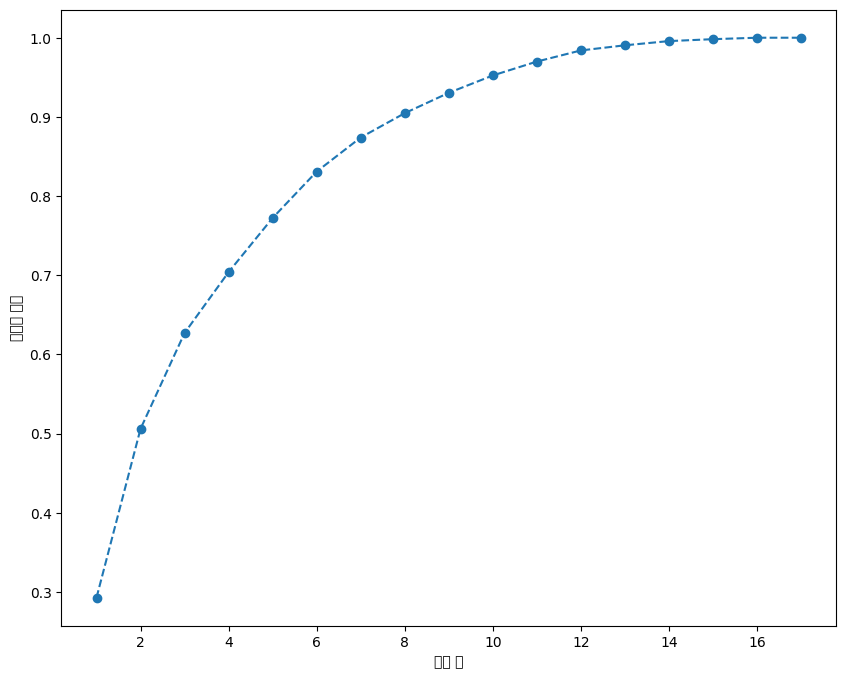

In [56]:
plt.figure(figsize=(10,8))
plt.plot(range(1,18),pca.explained_variance_ratio_.cumsum(), marker= "o", linestyle= "--")
plt.ylabel("설명된 분산")
plt.xlabel("차원 수")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

In [57]:
print ('Cumulative variance explained by 2 principal components: {:.6%}'.format(np.sum(pca_2.explained_variance_ratio_)))


Cumulative variance explained by 2 principal components: 83.091433%


In [58]:
pca_2_result = pca_2.fit_transform(sca_df)

In [59]:
results = pd.DataFrame(data=  pca_2.fit_transform(sca_df), columns=['PC-1','PC-2',"PC-3","PC-4","PC-5","PC-6"])

In [60]:
# 결과 출력
components_df = pd.DataFrame(pca_2.components_, columns=sca_df.columns,
                              index=results.columns)
components_df

,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%),도로율,노인_per,장애인_per,기초생활수급자_per,추정면적당시우량(연간),FREQUENCY
PC-1,0.001878,0.696912,0.639664,0.056076,-0.184230,-0.179282,-0.026447,-0.016445,-0.032936,0.025205,0.023103,-0.025455,0.103066,0.097221,0.098348,-0.039087,-0.027698
PC-2,-0.052130,-0.002306,0.172578,-0.087883,0.064967,-0.078428,-0.292370,-0.238288,-0.142303,0.085701,0.278839,0.270940,-0.465097,-0.435452,-0.421835,-0.210547,0.013216
PC-3,-0.004887,-0.613203,0.732361,0.060015,0.108719,0.078958,0.107655,0.132347,0.111928,-0.029903,-0.139715,-0.012683,-0.033079,0.014319,0.035810,-0.028242,0.019037
PC-4,-0.517952,0.113811,-0.006632,-0.362779,-0.027484,0.129436,0.259565,0.192363,0.038532,-0.223519,-0.174998,0.603806,-0.050567,0.067643,0.022687,-0.000727,0.104563
PC-5,-0.243783,-0.174772,0.063666,-0.107738,0.048160,0.122558,-0.393021,-0.336199,-0.195302,0.340727,0.321272,0.223860,0.250671,0.329088,0.327842,0.144896,-0.048501
PC-6,-0.499082,0.017375,0.077282,-0.322251,-0.130982,0.250014,-0.043599,-0.015310,-0.099523,-0.096966,0.082232,-0.640999,0.013932,-0.160508,-0.184552,0.248900,0.009082


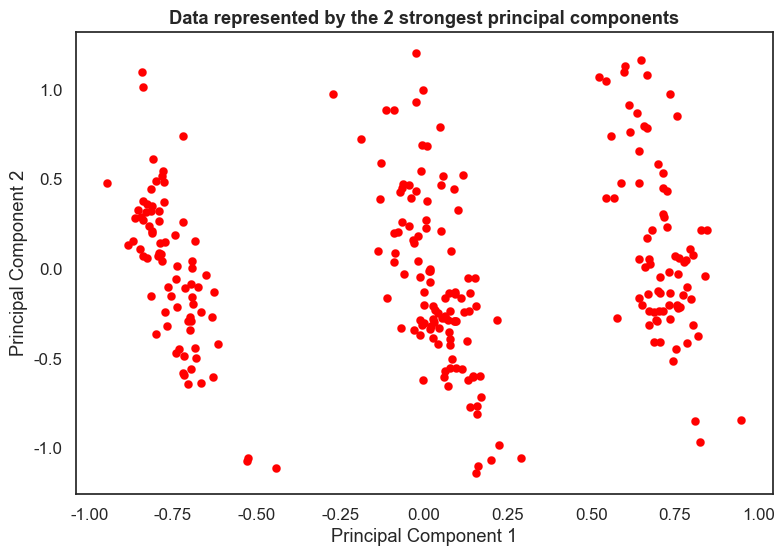

In [61]:
sb.set(style='white', rc={'figure.figsize':(9,6)},font_scale=1.1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], color='red',lw=0.1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data represented by the 2 strongest principal components',fontweight='bold')
plt.show()


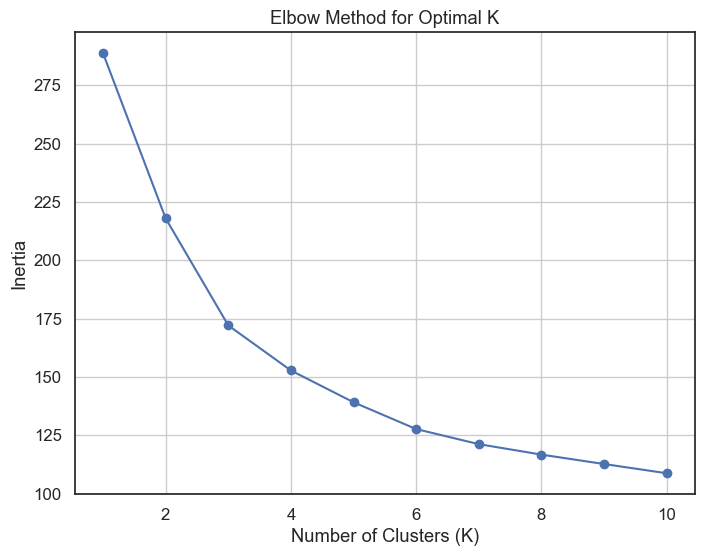

In [62]:
inertia = []

# Define the range of K values to test
k_range = range(1, 11)  # You can adjust this range based on your problem

# Calculate the inertia for different K values
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(sca_df)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()
plt.close()

3개의 클러스터로 구분하는 것이 적절하다고 판단할 수 있다.

In [63]:
sca_df

,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%),도로율,노인_per,장애인_per,기초생활수급자_per,추정면적당시우량(연간),FREQUENCY
0,0.652019,1.0,0.0,0.082400,0.153404,0.396933,0.075859,0.173948,0.421812,0.703835,0.614029,0.227698,0.025486,0.167128,0.162254,0.147864,0.001138
1,0.841125,0.0,0.0,0.164801,0.304146,0.650401,0.226233,0.303176,0.577498,0.811196,0.411324,0.227698,0.025486,0.167128,0.162254,0.147864,0.011377
2,0.678012,0.0,0.0,0.255864,0.582485,0.442661,0.232434,0.384465,0.719249,0.768676,0.344182,0.227698,0.025486,0.167128,0.162254,0.147864,0.015927
3,0.686136,0.0,0.0,0.228027,0.335382,0.624947,1.000000,0.719271,0.512024,0.128854,0.015338,0.347494,0.498653,0.627517,0.293673,0.466808,0.020478
4,0.607824,1.0,0.0,0.205789,0.132396,0.189810,0.532695,0.668979,1.000000,0.283669,0.114052,0.417162,0.446370,0.730774,0.662202,0.816063,0.062571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,0.927232,1.0,0.0,0.407131,0.213153,0.266984,0.524442,0.521793,0.689787,0.646000,0.168323,0.000000,0.457955,0.450709,0.362500,0.355019,0.005688
261,0.201420,1.0,0.0,0.087065,0.158519,0.827975,0.494297,0.505086,0.838754,0.540355,0.183280,0.118946,0.720071,0.644448,0.556509,1.000000,0.000000
262,0.935083,1.0,0.0,0.932836,0.305960,0.343119,0.882015,0.695723,0.695383,0.077379,0.054817,0.448598,0.574900,0.620578,0.551304,0.616442,0.001138
263,0.825656,1.0,0.0,0.481965,0.210900,0.098475,0.652988,0.419857,0.530795,0.245377,0.302099,0.118946,0.720071,0.644448,0.556509,1.000000,0.000000


In [64]:
from sklearn.metrics import silhouette_score, silhouette_samples
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor



In [65]:
inertia = []
for i in range(2,10):
    kmeans = KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(sca_df)
    inertia.append(kmeans.inertia_)

In [66]:
silhouette = {}
for i in range(2,10):
    kmeans = KMeans(n_clusters=i,
               init='k-means++',
               n_init=100,
               max_iter=500,
               random_state=17)
    kmeans.fit(sca_df)
    silhouette[i] = silhouette_score(sca_df, kmeans.labels_, metric='euclidean')

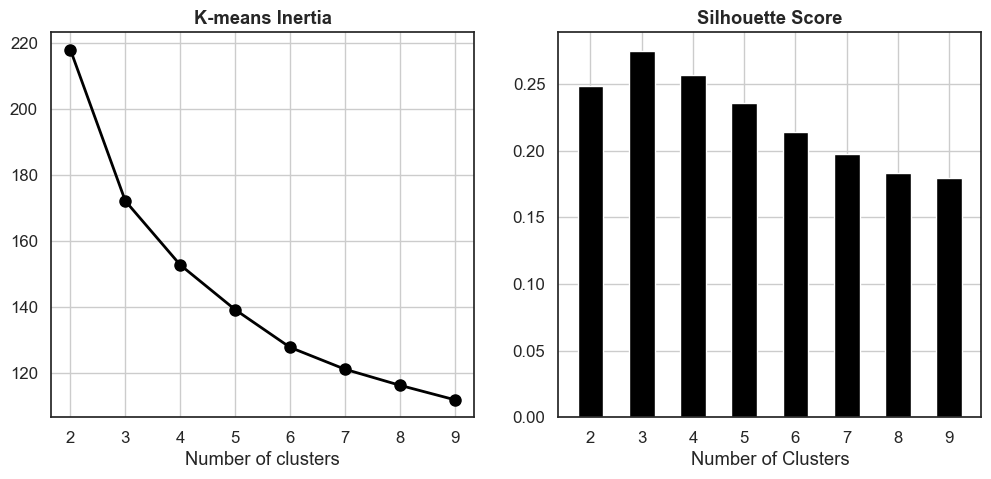

In [67]:
sb.set(style='white',font_scale=1.1, rc={'figure.figsize':(12,5)})

plt.subplot(1, 2, 1)

plt.plot(range(2,len(inertia)+2), inertia, marker='o',lw=2,ms=8,color='black')
plt.xlabel('Number of clusters')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2)

plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',color= 'black',width=0.5)
plt.xticks(range(len(silhouette)), list(silhouette.keys()))
plt.grid()  
plt.title('Silhouette Score',fontweight='bold')
plt.xlabel('Number of Clusters')


plt.show()

In [68]:
kmeans = KMeans(n_clusters=3)

y = kmeans.fit_predict(sca_df[['배수등급양호비율', '제방', '수문', '평균경사도(%)', '하천까지의거리(중심)', '인구밀도(명/km²)',
       '1분위소득가구비율(%)', '2분위소득가구비율(%)', '3분위소득가구비율(%)', '4분위소득가구비율(%)',
       '5분위소득가구비율(%)', '도로율', '노인_per', '장애인_per', '기초생활수급자_per', '추정면적당시우량(연간)', 'FREQUENCY']])
y

c:\Users\yis82\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([2, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 0, 0, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2,
       2, 2, 1, 2, 2, 1, 2, 0, 0, 0, 1, 1, 1, 1, 0, 0, 2, 2, 2, 2, 0, 0,
       2, 1, 2, 1, 2, 0, 1, 1, 0, 2, 2, 1, 0, 1, 1, 2, 2, 2, 1, 0, 0, 0,
       2, 1, 1, 0, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 2, 0, 1, 0, 2, 1, 1,
       2, 0, 1, 0, 2, 2, 2, 0, 2, 0, 1, 2, 2, 1, 1, 1, 0, 2, 0, 2, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 2, 1, 1, 2, 1, 2, 2, 1, 0, 2, 2, 2, 2, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 0, 0, 2, 2, 0, 1, 1, 2, 2,
       1, 2, 2, 0, 0, 2, 2, 1, 0, 2, 1, 0, 0, 2, 0, 1, 2, 2, 1, 1, 2, 0,
       0, 0, 0, 2, 2, 0, 0, 1, 2, 0, 1, 0, 1, 0, 2, 2, 1, 2, 2, 0, 2, 2,
       0, 0, 2, 2, 1, 0, 2, 2, 1, 0, 2, 1, 0, 2, 1, 2, 0, 0, 2, 0, 0, 2,
       2, 1, 1, 2, 1, 2, 0, 1, 1, 0, 2, 0, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2,
       1])

In [69]:
pca_score = pca.transform(sca_df)

In [70]:
kmeans = KMeans(n_clusters=3,random_state=17,init='k-means++')
kmeans_labels = kmeans.fit_predict(pca_score)

centroids = kmeans.cluster_centers_
centroids_pca = pca_2.transform(centroids)

pd.Series(kmeans_labels).value_counts() 

c:\Users\yis82\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\yis82\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


1    108
2     80
0     77
Name: count, dtype: int64

In [71]:
df_pca_kmeans = pd.concat([sca_df, pd.DataFrame({"Segment K-means PCA":kmeans_labels})],axis=1)
df_pca_kmeans.drop(['FREQUENCY'],axis=1)
df_pca_kmeans["FREQUENCY"] = df["FREQUENCY"]

In [72]:
df_pca_kmeans.groupby('Segment K-means PCA')["FREQUENCY"].median()

Segment K-means PCA
0     7.0
1     4.0
2    14.5
Name: FREQUENCY, dtype: float64

In [73]:
df_pca_kmeans

,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%),도로율,노인_per,장애인_per,기초생활수급자_per,추정면적당시우량(연간),FREQUENCY,Segment K-means PCA
0,0.652019,1.0,0.0,0.082400,0.153404,0.396933,0.075859,0.173948,0.421812,0.703835,0.614029,0.227698,0.025486,0.167128,0.162254,0.147864,2,1
1,0.841125,0.0,0.0,0.164801,0.304146,0.650401,0.226233,0.303176,0.577498,0.811196,0.411324,0.227698,0.025486,0.167128,0.162254,0.147864,11,2
2,0.678012,0.0,0.0,0.255864,0.582485,0.442661,0.232434,0.384465,0.719249,0.768676,0.344182,0.227698,0.025486,0.167128,0.162254,0.147864,15,2
3,0.686136,0.0,0.0,0.228027,0.335382,0.624947,1.000000,0.719271,0.512024,0.128854,0.015338,0.347494,0.498653,0.627517,0.293673,0.466808,19,2
4,0.607824,1.0,0.0,0.205789,0.132396,0.189810,0.532695,0.668979,1.000000,0.283669,0.114052,0.417162,0.446370,0.730774,0.662202,0.816063,56,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,0.927232,1.0,0.0,0.407131,0.213153,0.266984,0.524442,0.521793,0.689787,0.646000,0.168323,0.000000,0.457955,0.450709,0.362500,0.355019,6,1
261,0.201420,1.0,0.0,0.087065,0.158519,0.827975,0.494297,0.505086,0.838754,0.540355,0.183280,0.118946,0.720071,0.644448,0.556509,1.000000,1,1
262,0.935083,1.0,0.0,0.932836,0.305960,0.343119,0.882015,0.695723,0.695383,0.077379,0.054817,0.448598,0.574900,0.620578,0.551304,0.616442,2,1
263,0.825656,1.0,0.0,0.481965,0.210900,0.098475,0.652988,0.419857,0.530795,0.245377,0.302099,0.118946,0.720071,0.644448,0.556509,1.000000,1,1


In [74]:
통합[통합['도로율'] >28]

,GU_NAME,ADM_NM,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%),도로율,노인_per,장애인_per,기초생활수급자_per,기초생활수급자+65세이상_per,추정면적당시우량(연간),침수여부
52,마포구,공덕동,0.629139,0.0,0.0,10.416667,3528.533207,37022.772280,0.186286,0.197853,0.209798,0.197475,0.208588,28.69,14.380320,3.568869,2.955082,1.231673,0.340047,1.0
61,광진구,광장동,0.816842,1.0,1.0,11.531250,349.908920,14328.451880,0.078069,0.075792,0.141245,0.194745,0.510055,29.13,14.672661,3.649844,3.890369,1.232481,0.490508,0.0
79,광진구,구의1동,0.569444,0.0,0.0,8.833333,1312.785063,43028.571430,0.208128,0.217329,0.265856,0.190273,0.118414,29.13,14.672661,3.649844,3.890369,1.232481,0.490508,0.0
80,광진구,구의2동,0.872093,1.0,0.0,23.687500,1267.687752,18994.964030,0.189062,0.182474,0.234307,0.224487,0.169795,29.13,14.672661,3.649844,3.890369,1.232481,0.490508,0.0
82,광진구,구의3동,0.327957,1.0,0.0,8.812500,421.427460,27847.058820,0.116433,0.128119,0.195810,0.217181,0.342457,29.13,14.672661,3.649844,3.890369,1.232481,0.490508,0.0
84,광진구,군자동,0.589189,1.0,0.0,5.100000,1227.235950,28932.432430,0.255819,0.251060,0.246819,0.150409,0.095997,29.13,14.672661,3.649844,3.890369,1.232481,0.490508,0.0
118,광진구,능동,0.868613,1.0,0.0,6.125000,2000.660166,10474.545450,0.215073,0.208058,0.278413,0.165765,0.132692,29.13,14.672661,3.649844,3.890369,1.232481,0.490508,0.0
124,영등포구,당산1동,0.250000,0.0,0.0,1.000000,1330.402288,28237.333330,0.171242,0.187971,0.217086,0.231133,0.192696,29.23,15.888026,3.889959,3.044485,1.321272,0.355214,1.0
125,영등포구,당산2동,0.481928,1.0,0.0,0.666667,1481.675303,23983.870970,0.132036,0.174559,0.199640,0.219892,0.273874,29.23,15.888026,3.889959,3.044485,1.321272,0.355214,1.0
127,영등포구,대림1동,0.694118,0.0,0.0,8.000000,706.587694,33404.081630,0.330179,0.266939,0.182405,0.147989,0.072489,29.23,15.888026,3.889959,3.044485,1.321272,0.355214,1.0


In [75]:
centroids_pca[:,1]

array([0.78484667, 0.69538422, 0.85310021])

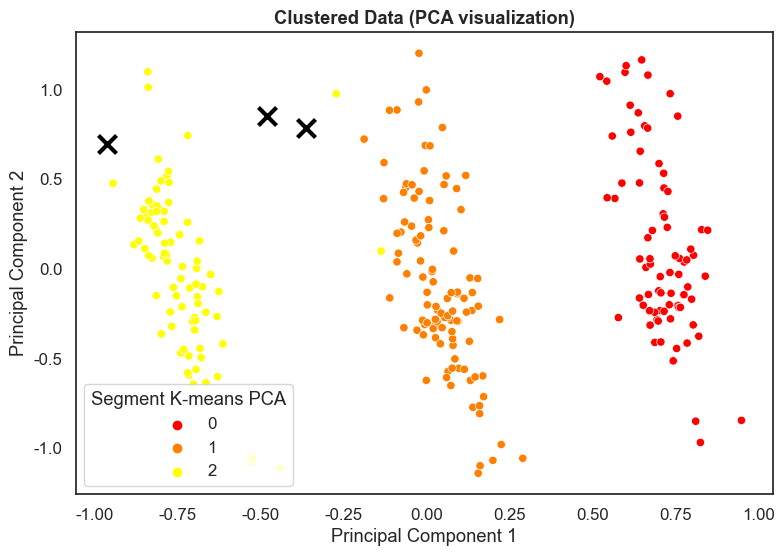

In [76]:
sb.set(style='white', rc={'figure.figsize':(9,6)},font_scale=1.1)
x_axis = pca_2_result[:, 0]
y_axis =pca_2_result[:, 1]
sb.scatterplot(x=x_axis, y=y_axis, hue=df_pca_kmeans["Segment K-means PCA"], palette='autumn')
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
            marker='x', s=169, linewidths=3,
            color='black', zorder=10,lw=3)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustered Data (PCA visualization)',fontweight='bold')
plt.show()


In [77]:
sca_df

,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%),도로율,노인_per,장애인_per,기초생활수급자_per,추정면적당시우량(연간),FREQUENCY
0,0.652019,1.0,0.0,0.082400,0.153404,0.396933,0.075859,0.173948,0.421812,0.703835,0.614029,0.227698,0.025486,0.167128,0.162254,0.147864,0.001138
1,0.841125,0.0,0.0,0.164801,0.304146,0.650401,0.226233,0.303176,0.577498,0.811196,0.411324,0.227698,0.025486,0.167128,0.162254,0.147864,0.011377
2,0.678012,0.0,0.0,0.255864,0.582485,0.442661,0.232434,0.384465,0.719249,0.768676,0.344182,0.227698,0.025486,0.167128,0.162254,0.147864,0.015927
3,0.686136,0.0,0.0,0.228027,0.335382,0.624947,1.000000,0.719271,0.512024,0.128854,0.015338,0.347494,0.498653,0.627517,0.293673,0.466808,0.020478
4,0.607824,1.0,0.0,0.205789,0.132396,0.189810,0.532695,0.668979,1.000000,0.283669,0.114052,0.417162,0.446370,0.730774,0.662202,0.816063,0.062571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,0.927232,1.0,0.0,0.407131,0.213153,0.266984,0.524442,0.521793,0.689787,0.646000,0.168323,0.000000,0.457955,0.450709,0.362500,0.355019,0.005688
261,0.201420,1.0,0.0,0.087065,0.158519,0.827975,0.494297,0.505086,0.838754,0.540355,0.183280,0.118946,0.720071,0.644448,0.556509,1.000000,0.000000
262,0.935083,1.0,0.0,0.932836,0.305960,0.343119,0.882015,0.695723,0.695383,0.077379,0.054817,0.448598,0.574900,0.620578,0.551304,0.616442,0.001138
263,0.825656,1.0,0.0,0.481965,0.210900,0.098475,0.652988,0.419857,0.530795,0.245377,0.302099,0.118946,0.720071,0.644448,0.556509,1.000000,0.000000


In [78]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors # 차이: KNN 지도학습 <-> NearestNeighbors 비지도학습
from itertools import combinations, product


In [79]:
neighbors = NearestNeighbors(n_neighbors=3)
neighbors_fit = neighbors.fit(sca_df)
distances, indices = neighbors_fit.kneighbors(sca_df)
s_distances = np.sort(distances, axis=0)

In [80]:
target = s_distances[:,1]
target


array([0.1335177 , 0.1335177 , 0.13980291, 0.13980291, 0.15832003,
       0.15832003, 0.16789224, 0.16789224, 0.17119197, 0.17714398,
       0.17714398, 0.17863837, 0.18714645, 0.18714645, 0.19249335,
       0.1925345 , 0.1925345 , 0.19796373, 0.19796373, 0.20248441,
       0.20248441, 0.21242339, 0.21242339, 0.21803774, 0.21803774,
       0.22291847, 0.22291847, 0.23828416, 0.25080325, 0.25080325,
       0.25092558, 0.25092558, 0.2618844 , 0.26282491, 0.26282491,
       0.27084962, 0.27084962, 0.27353177, 0.28728608, 0.28728608,
       0.29133907, 0.29177499, 0.29177499, 0.29517857, 0.29517857,
       0.29978076, 0.30209791, 0.30209791, 0.30699317, 0.31315841,
       0.31315841, 0.314611  , 0.314611  , 0.32230952, 0.32230952,
       0.3229952 , 0.3229952 , 0.32779186, 0.32779186, 0.33283209,
       0.33283209, 0.33454278, 0.33454278, 0.33780604, 0.33780604,
       0.34227064, 0.34227064, 0.34480645, 0.34602004, 0.34602004,
       0.34706487, 0.34706487, 0.34719843, 0.34829855, 0.35217

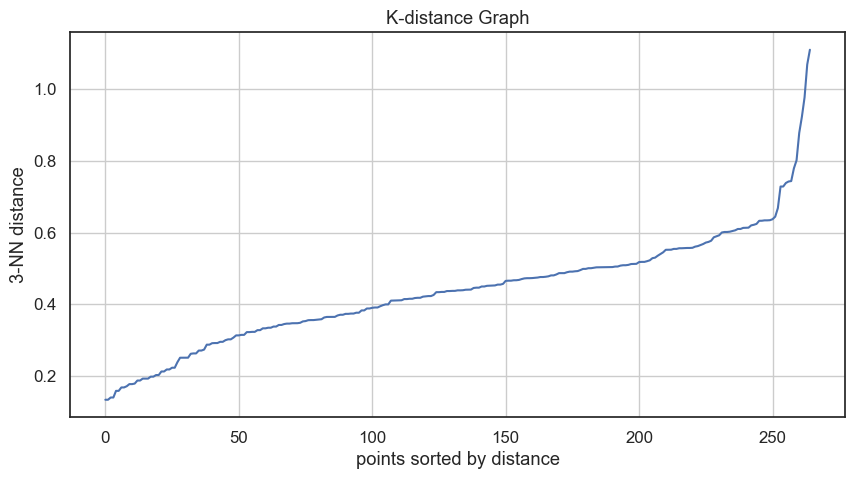

In [81]:
plt.figure(figsize=(10,5))
plt.plot(target)
plt.grid()
plt.title('K-distance Graph')
plt.ylabel("3-NN distance")
plt.xlabel("points sorted by distance")
plt.show()
plt.close()

In [82]:
eps = [0.7,0.75]
minPts = [5, 6]

In [83]:
prod = list(product(*[eps, minPts]))
prod


[(0.7, 5), (0.7, 6), (0.75, 5), (0.75, 6)]

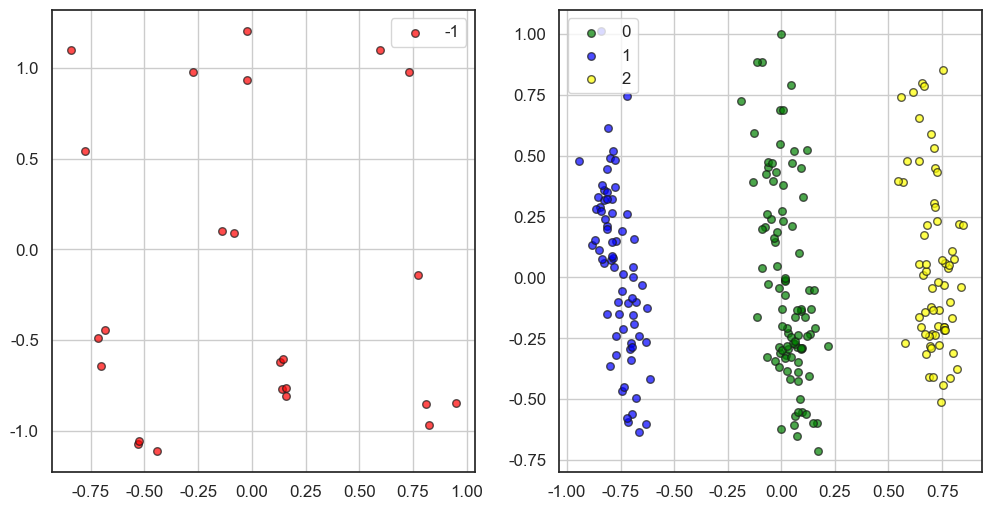

In [84]:

# Initialize the DBSCAN model
model = DBSCAN(eps=0.7, min_samples=5)

# Fit the model to the data and get the cluster labels
predict = pd.DataFrame(model.fit_predict(pca_score))
predict.columns = ['predict']


# Concatenate the cluster labels with your data
r = pd.concat([sca_df, predict], axis=1)
r["x_axis"] = x_axis
r['y_axis'] = y_axis
# Define unique colors for each cluster label
label_colors = {-1: 'red', 0: 'green', 1: 'blue', 2: 'yellow'}

# Create subplots for scatter plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Iterate through cluster labels and plot data points with unique colors
for label, color in label_colors.items():
    if label == -1:
        ax1.scatter(r[r['predict'] == label]['x_axis'], r[r['predict'] == label]['y_axis'], label=label, c=color, s=30, edgecolors='k', alpha=0.7)
    else:
        ax2.scatter(r[r['predict'] == label]['x_axis'], r[r['predict'] == label]['y_axis'], label=label, c=color, s=30, edgecolors='k', alpha=0.7)

# Add legends and grids to the subplots
ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()

# Show the scatter plots
plt.show()


In [85]:
import pandas as pd

def process_cluster_label(data, cluster_label):
    # Filter data for the specified cluster label
    cluster_data = data[data['predict'] == cluster_label]

    # Drop unnecessary columns
    cluster_data = cluster_data.drop(['FREQUENCY', 'predict', 'x_axis', 'y_axis'], axis=1)

    # Add the 'FREQUENCY' column from the original data
    cluster_data = cluster_data.merge(data[['FREQUENCY']], left_index=True, right_index=True)


    return cluster_data

r_group = {}
for i in range(0,3):
    r_group[i] = process_cluster_label(r, i)

In [86]:
def backward_elimination(X, y):
    included = list(X.columns)
    
    while True:
        model = sm.OLS(endog=y, exog=X[included]).fit()
        rsquard_adj = model.rsquared_adj
        worst_feature = None
        changed=False
        
        for feature in included:
            droped_feature=[x for x in included if x!=feature]
            droped_model=sm.OLS(endog=y, exog=X[droped_feature]).fit()
            if droped_model.rsquared_adj > rsquard_adj:
                #print(droped_model.rsquared_adj,rsquard_adj)
                worst_feature = feature
                break
        #print(included)
        if worst_feature:
            included.remove(worst_feature)
            changed = True
        
        if not changed:
            break
    
    model = sm.OLS(y,X[included]).fit()
    return model #, included, rsquard_adj

In [87]:
r_group[0]["FREQUENCY"] = data["FREQUENCY"]
r_group[1]["FREQUENCY"] = data["FREQUENCY"]
r_group[2]["FREQUENCY"] = data["FREQUENCY"]

In [88]:
data[data["FREQUENCY"] == 527] 

,GU_NAME,ADM_NM,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),...,4분위소득가구비율(%),5분위소득가구비율(%),도로율,노인_per,장애인_per,기초생활수급자_per,기초생활수급자+65세이상_per,추정면적당시우량(연간),침수여부,FREQUENCY
42,영등포구,대림1동,0.694118,0.0,0.0,8.0,706.587694,33404.08163,0.330179,0.266939,...,0.147989,0.072489,29.23,15.888026,3.889959,3.044485,1.321272,0.355214,1.0,527


(array([75.,  7.,  5.,  3.,  1.,  0.,  2.,  0.,  0.,  2.]),
 array([  1. ,  24.2,  47.4,  70.6,  93.8, 117. , 140.2, 163.4, 186.6,
        209.8, 233. ]),
 <BarContainer object of 10 artists>)

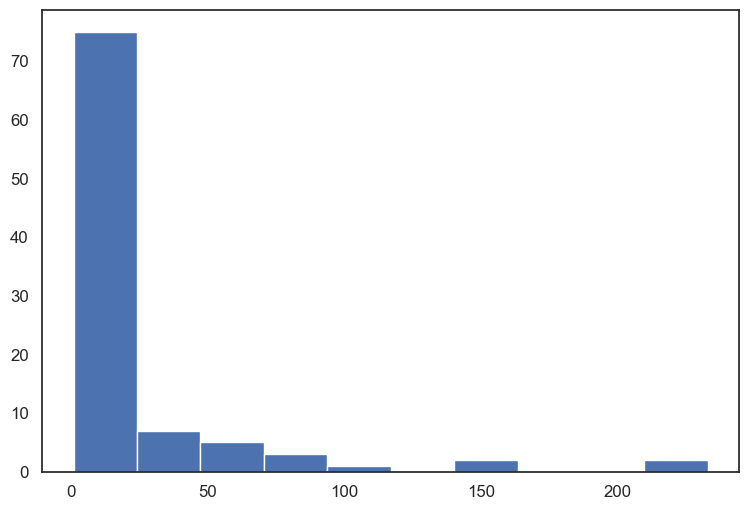

In [89]:
plt.hist(x=r_group[0]['FREQUENCY'])

(array([48., 14.,  2.,  1.,  1.,  1.,  1.,  1.,  0.,  1.]),
 array([  1. ,  53.6, 106.2, 158.8, 211.4, 264. , 316.6, 369.2, 421.8,
        474.4, 527. ]),
 <BarContainer object of 10 artists>)

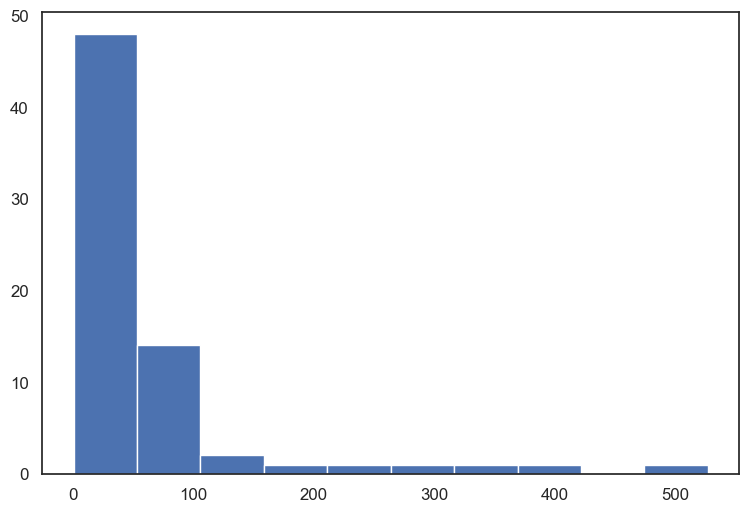

In [90]:
plt.hist(r_group[1]["FREQUENCY"])

In [91]:
plt.hist(r_group[2]["FREQUENCY"], range=)

SyntaxError: invalid syntax (4116818637.py, line 1)

In [ ]:
model_0 = backward_elimination(r_group[0].drop(['FREQUENCY'],axis=1),r_group[0]["FREQUENCY"])
model_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              FREQUENCY   R-squared (uncentered):                   0.362
Model:                            OLS   Adj. R-squared (uncentered):              0.303
Method:                 Least Squares   F-statistic:                              6.158
Date:                Thu, 02 Nov 2023   Prob (F-statistic):                    2.79e-06
Time:                        11:56:36   Log-Likelihood:                         -479.06
No. Observations:                  95   AIC:                                      974.1
Df Residuals:                      87   BIC:                                      994.6
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
배수등급양호비율       -19.0375     13.958     -1.364      0.176     -46.780       8.705
인구밀도(명/km²)     26.6341     20.322      1.311      0.193     -13.757      67.026
4분위소득가구비율(%)    30.2321     24.923      1.213      0.228     -19.304      79.769
5분위소득가구비율(%)   -31.3045     28.721     -1.090      0.279     -88.391      25.782
도로율             38.7575     14.947      2.593      0.011       9.049      68.466
장애인_per         57.0255     45.649      1.249      0.215     -33.707     147.758
기초생활수급자_per   -106.3630     38.485     -2.764      0.007    -182.855     -29.871
추정면적당시우량(연간)    31.7666     24.428      1.300      0.197     -16.787      80.320
==============================================================================
Omnibus:                       61.437   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              249.229
Skew:                           2.200   Prob(JB):                     7.60e-55
Kurtosis:                       9.603   Cond. No.                         20.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
model_1 = backward_elimination(r_group[1].drop(['FREQUENCY'],axis=1),r_group[1]["FREQUENCY"])
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              FREQUENCY   R-squared (uncentered):                   0.493
Model:                            OLS   Adj. R-squared (uncentered):              0.446
Method:                 Least Squares   F-statistic:                              10.39
Date:                Thu, 02 Nov 2023   Prob (F-statistic):                    5.14e-08
Time:                        11:57:15   Log-Likelihood:                         -404.63
No. Observations:                  70   AIC:                                      821.3
Df Residuals:                      64   BIC:                                      834.7
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
하천까지의거리(중심)   -128.6922     59.162     -2.175      0.033    -246.881     -10.503
2분위소득가구비율(%)   319.2086     84.942      3.758      0.000     149.517     488.900
3분위소득가구비율(%)   -94.1792     67.355     -1.398      0.167    -228.736      40.378
도로율            109.4613     33.450      3.272      0.002      42.636     176.286
기초생활수급자_per   -174.2106     71.364     -2.441      0.017    -316.776     -31.645
추정면적당시우량(연간)    66.9905     56.006      1.196      0.236     -44.894     178.875
==============================================================================
Omnibus:                       31.248   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.671
Skew:                           1.489   Prob(JB):                     1.23e-15
Kurtosis:                       6.831   Cond. No.                         12.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
model_2 = backward_elimination(r_group[2].drop(['FREQUENCY'],axis=1),r_group[2]["FREQUENCY"])
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              FREQUENCY   R-squared (uncentered):                   0.447
Model:                            OLS   Adj. R-squared (uncentered):              0.400
Method:                 Least Squares   F-statistic:                              9.522
Date:                Thu, 02 Nov 2023   Prob (F-statistic):                    1.07e-06
Time:                        11:57:34   Log-Likelihood:                         -307.31
No. Observations:                  64   AIC:                                      624.6
Df Residuals:                      59   BIC:                                      635.4
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
2분위소득가구비율(%)    67.7951     16.123      4.205      0.000      35.534     100.056
5분위소득가구비율(%)    39.3820     23.671      1.664      0.101      -7.983      86.747
도로율            -56.3398     19.097     -2.950      0.005     -94.553     -18.127
노인_per         -25.8280     19.641     -1.315      0.194     -65.129      13.473
추정면적당시우량(연간)    48.5548     23.547      2.062      0.044       1.438      95.672
==============================================================================
Omnibus:                       56.868   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.409
Skew:                           2.574   Prob(JB):                     5.26e-64
Kurtosis:                      12.099   Cond. No.                         7.09
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
sca_df['label'] = y

In [ ]:
group_0 = df_pca_kmeans[df_pca_kmeans['Segment K-means PCA'] == 0]  
group_1 = df_pca_kmeans[df_pca_kmeans['Segment K-means PCA'] == 1]  
group_2 = df_pca_kmeans[df_pca_kmeans['Segment K-means PCA'] == 2]  

In [ ]:
group_1

,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%),도로율,노인_per,장애인_per,기초생활수급자_per,추정면적당시우량(연간),FREQUENCY,Segment K-means PCA
0,0.652019,1.0,0.0,0.082400,0.153404,0.396933,0.075859,0.173948,0.421812,0.703835,0.614029,0.227698,0.025486,0.167128,0.162254,0.147864,2,1
4,0.607824,1.0,0.0,0.205789,0.132396,0.189810,0.532695,0.668979,1.000000,0.283669,0.114052,0.417162,0.446370,0.730774,0.662202,0.816063,56,1
5,0.674044,1.0,0.0,0.230100,0.054973,0.127804,0.461881,0.380115,0.853267,0.616177,0.235035,0.313509,0.640394,0.494446,0.318602,0.213761,1,1
6,0.862398,1.0,0.0,0.471600,0.471093,0.299372,0.398894,0.506262,0.920800,0.690689,0.169481,0.397621,0.551421,0.628180,0.604230,0.166993,3,1
7,0.862052,1.0,0.0,0.446630,0.286012,0.575878,0.338395,0.456014,0.916666,0.778313,0.201801,0.397621,0.551421,0.628180,0.604230,0.166993,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,0.942502,1.0,0.0,0.182421,0.236633,0.332303,0.725556,0.603638,0.763346,0.297698,0.102278,0.313509,0.640394,0.494446,0.318602,0.213761,1,1
260,0.927232,1.0,0.0,0.407131,0.213153,0.266984,0.524442,0.521793,0.689787,0.646000,0.168323,0.000000,0.457955,0.450709,0.362500,0.355019,6,1
261,0.201420,1.0,0.0,0.087065,0.158519,0.827975,0.494297,0.505086,0.838754,0.540355,0.183280,0.118946,0.720071,0.644448,0.556509,1.000000,1,1
262,0.935083,1.0,0.0,0.932836,0.305960,0.343119,0.882015,0.695723,0.695383,0.077379,0.054817,0.448598,0.574900,0.620578,0.551304,0.616442,2,1


### 클러스터 별 RandomForest분석으로 Feature Importance 확인

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(group_0.drop(['FREQUENCY'],axis=1), group_0['FREQUENCY'])

# Extract feature importance scores
feature_importance = clf.feature_importances_

# Map feature importance scores to feature names (if available)
feature_names = group_0.drop(["FREQUENCY"],axis=1).columns
feature_importance_mapping = dict(zip(feature_names, feature_importance))

# Sort and print feature importance
sorted_feature_importance = sorted(feature_importance_mapping.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: 노인_per, Importance: 0.13893951166678437
Feature: 평균경사도(%), Importance: 0.11432267337405687
Feature: 4분위소득가구비율(%), Importance: 0.10769230769230767
Feature: 도로율, Importance: 0.09591567852437417
Feature: 배수등급양호비율, Importance: 0.09241410763149888
Feature: 3분위소득가구비율(%), Importance: 0.09099399795051973
Feature: 2분위소득가구비율(%), Importance: 0.08848365073661514
Feature: 5분위소득가구비율(%), Importance: 0.06539705353934602
Feature: 1분위소득가구비율(%), Importance: 0.06409749670619234
Feature: 인구밀도(명/km²), Importance: 0.04907773386034256
Feature: 기초생활수급자_per, Importance: 0.04150197628458497
Feature: 장애인_per, Importance: 0.037329819938515585
Feature: 추정면적당시우량(연간), Importance: 0.013833992094861658
Feature: 제방, Importance: 0.0
Feature: 수문, Importance: 0.0
Feature: 하천까지의거리(중심), Importance: 0.0
Feature: Segment K-means PCA, Importance: 0.0


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(group_1.drop(['FREQUENCY'],axis=1), group_1['FREQUENCY'])

# Extract feature importance scores
feature_importance = clf.feature_importances_

# Map feature importance scores to feature names (if available)
feature_names = group_1.drop(["FREQUENCY"],axis=1).columns
feature_importance_mapping = dict(zip(feature_names, feature_importance))

# Sort and print feature importance
sorted_feature_importance = sorted(feature_importance_mapping.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: 인구밀도(명/km²), Importance: 0.14787660649273549
Feature: 평균경사도(%), Importance: 0.12159084658122006
Feature: 4분위소득가구비율(%), Importance: 0.10768031035760771
Feature: 3분위소득가구비율(%), Importance: 0.10662553431075938
Feature: 5분위소득가구비율(%), Importance: 0.09606438731348754
Feature: 1분위소득가구비율(%), Importance: 0.06911271247043291
Feature: 추정면적당시우량(연간), Importance: 0.06807669159307923
Feature: 기초생활수급자_per, Importance: 0.06163705374333022
Feature: 노인_per, Importance: 0.05961078975190274
Feature: 배수등급양호비율, Importance: 0.05676879916387041
Feature: 2분위소득가구비율(%), Importance: 0.043319214478244134
Feature: 장애인_per, Importance: 0.030447219318994447
Feature: 하천까지의거리(중심), Importance: 0.02079322294955718
Feature: 도로율, Importance: 0.01039661147477859
Feature: 제방, Importance: 0.0
Feature: 수문, Importance: 0.0
Feature: Segment K-means PCA, Importance: 0.0


In [ ]:
from sklearn.tree import DecisionTreeClassifier


# Create a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(group_2.drop(['FREQUENCY'],axis=1), group_2['FREQUENCY'])

# Extract feature importance scores
feature_importance = clf.feature_importances_

# Map feature importance scores to feature names (if available)
feature_names = group_2.drop(["FREQUENCY"],axis=1).columns
feature_importance_mapping = dict(zip(feature_names, feature_importance))

# Sort and print feature importance
sorted_feature_importance = sorted(feature_importance_mapping.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: 3분위소득가구비율(%), Importance: 0.1628233342901795
Feature: 1분위소득가구비율(%), Importance: 0.11565014495418899
Feature: 인구밀도(명/km²), Importance: 0.10911246142324506
Feature: 배수등급양호비율, Importance: 0.08324562242847573
Feature: 5분위소득가구비율(%), Importance: 0.08107677096290625
Feature: 평균경사도(%), Importance: 0.07651226003536787
Feature: 2분위소득가구비율(%), Importance: 0.07144451886581825
Feature: 기초생활수급자_per, Importance: 0.06944749076246458
Feature: 하천까지의거리(중심), Importance: 0.06315185149746434
Feature: 노인_per, Importance: 0.0627297134526952
Feature: 4분위소득가구비율(%), Importance: 0.0334896182183523
Feature: 장애인_per, Importance: 0.031894874493668866
Feature: 도로율, Importance: 0.02602549132783203
Feature: 추정면적당시우량(연간), Importance: 0.013395847287340923
Feature: 제방, Importance: 0.0
Feature: 수문, Importance: 0.0
Feature: Segment K-means PCA, Importance: 0.0


In [ ]:
regression_models["group_0"].summary()

NameError: name 'regression_models' is not defined

In [ ]:
regression_models["group_1"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              FREQUENCY   R-squared (uncentered):                   0.376
Model:                            OLS   Adj. R-squared (uncentered):              0.334
Method:                 Least Squares   F-statistic:                              9.039
Date:                Wed, 01 Nov 2023   Prob (F-statistic):                    9.30e-07
Time:                        11:10:47   Log-Likelihood:                         -465.92
No. Observations:                  80   AIC:                                      941.8
Df Residuals:                      75   BIC:                                      953.7
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
하천까지의거리(중심)   -85.0817     49.686     -1.712      0.091    -184.061      13.897
인구밀도(명/km²)    72.8045     41.654      1.748      0.085     -10.175     155.784
도로율           117.4071     32.509      3.612      0.001      52.647     182.167
노인_per        132.5406     65.143      2.035      0.045       2.768     262.313
기초생활수급자_per  -145.2207     70.621     -2.056      0.043    -285.906      -4.536
==============================================================================
Omnibus:                       50.191   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              169.689
Skew:                           2.060   Prob(JB):                     1.42e-37
Kurtosis:                       8.825   Cond. No.                         9.88
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
regression_models["group_2"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              FREQUENCY   R-squared (uncentered):                   0.318
Model:                            OLS   Adj. R-squared (uncentered):              0.281
Method:                 Least Squares   F-statistic:                              8.511
Date:                Wed, 01 Nov 2023   Prob (F-statistic):                    1.08e-05
Time:                        11:10:47   Log-Likelihood:                         -385.31
No. Observations:                  77   AIC:                                      778.6
Df Residuals:                      73   BIC:                                      788.0
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
평균경사도(%)       35.2489     16.983      2.076      0.041       1.401      69.097
하천까지의거리(중심)    39.4243     27.145      1.452      0.151     -14.675      93.524
인구밀도(명/km²)    51.3636     17.136      2.997      0.004      17.212      85.515
기초생활수급자_per   -33.5038     15.876     -2.110      0.038     -65.144      -1.864
==============================================================================
Omnibus:                       70.448   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              398.506
Skew:                           2.930   Prob(JB):                     2.92e-87
Kurtosis:                      12.480   Cond. No.                         4.95
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
plt.figure(figsize=(10, 7))
tmp_x = std_x[:,:2]
for i in range(n):
    points = tmp_x[clusters == i]
    plt.scatter(points[:, 0], points[:, 1], label=f'cluster {i+1}')

    hull = ConvexHull(points)
    vert = np.append(hull.vertices, hull.vertices[0])  # close the polygon by appending the first point at the end
    plt.plot(points[vert, 0], points[vert, 1], '--', )
    plt.fill(points[vert, 0], points[vert, 1], alpha=0.2)

plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', label='Centroids', marker='x')

plt.legend()
plt.show()
plt.close()


NameError: name 'std_x' is not defined

<Figure size 1000x700 with 0 Axes>

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering


In [ ]:
lnk = linkage(df, method='ward', metric = 'euclidean')
lnk

array([[4.70000000e+01, 2.01000000e+02, 1.86178004e+01, 2.00000000e+00],
       [1.67000000e+02, 2.36000000e+02, 2.76427472e+01, 2.00000000e+00],
       [2.09000000e+02, 2.38000000e+02, 3.40649049e+01, 2.00000000e+00],
       ...,
       [5.21000000e+02, 5.22000000e+02, 6.03660300e+04, 9.40000000e+01],
       [5.24000000e+02, 5.25000000e+02, 1.00566033e+05, 1.71000000e+02],
       [5.26000000e+02, 5.27000000e+02, 2.07430235e+05, 2.65000000e+02]])